In [85]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = 'C:\ffmpeg'
import matplotlib.animation as animation

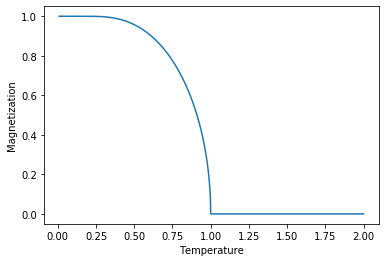

In [2]:
## Constants
Tmax = 2.0
points = 1000
accuracy = 1e-6

## Set up lists for plotting
y = []
temp = np.linspace(0.01,Tmax,points)

## Temperature loop
for T in temp:
    m1 = 1.0
    error = 1.0
    
    ## Loop until desired error
    while error>accuracy:
        m1,m2 = math.tanh(m1/T),m1
        error = abs((m1-m2)/(1-T*math.cosh(m2/T)**2))
        
    y.append(m1)
    
## Plot graph
plt.plot(temp,y)
#py.ylim(-0.1,1.1)
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.show()

# Ising Model

In [3]:
import random
import math

In [4]:
def createLattice(rows, cols):
    '''function that returns an array of dimensions rows by columns, 
    where each site in array is filled with integer 1'''
    
    return np.ones((rows, cols))

In [5]:
## create an array for testing and print array
testSize = 4
testSpinArray = createLattice(testSize,testSize)
print(testSpinArray)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [6]:
def find_neighbors(spin_array, size, i, j):
    '''
    Summary: function to find the nearest neighbors of a specific site in a lattice. For some lattice sites, 
             to avoid counting unique pairs twice, sites below the top row and sites beyond the left row only count 
             nearest neighbors below and above. This function uses a repeating lattice to count nearest neighbors.
    
    Parameters: spin_array - a two dimensional array representing a lattice
                size - length and width of the lattice
                i - variable representing the i'th row
                j - variable representing the j'th row
    
    
    Returns: the product of the sites interactions with it's nearest neighbors.
    '''
    ##calculating nearest neighbors to the site
    left   = spin_array[(i, j - 1)]
    right  = spin_array[(i, (j + 1) % size)]
    top    = spin_array[(i - 1, j)]
    bottom = spin_array[((i + 1) % size, j)]
    
    ##conditions for specific lattice sites
    if i != 0:
        top = 0
    if j != 0:
        left = 0

    return left*spin_array[i,j]+right*spin_array[i,j]+top*spin_array[i,j]+bottom*spin_array[i,j]

In [44]:
def systemEnergy(spin_array, size, J):
    '''
    Summary: calculates the energy of a lattice
    
    Parameters: spin_array - a two dimensional array representing a lattice
                size - length and width of the lattice
                J - a positive interaction constant
    
    Returns: the energy of the system
    '''
    '''
    ##initialize the energy as zero
    sumEnergy = 0
    
    ##loop through lattice, summing the energies
    for i in range(0,size):
        for j in range(0,size):
            sumEnergy += find_neighbors(spin_array, size,i,j)
            
    return -J * sumEnergy
    '''
    s1 = spin_array[:-1,:] * spin_array[1:,:]
    s2 = spin_array[:,:-1] * spin_array[:,1:]
    
    return - J * (np.sum(s1)+ np.sum(s2))

In [45]:
## energy should be -40 w/ size = 4, using nearest neighbors and treating the lattice as repeating
J = 1
print(systemEnergy(testSpinArray,testSize,J))

-2.0


In [9]:
def initializeLattice(spin_array,size):
    '''
    Summary: initializes an inputted lattice for the Ising model with each site being randomly determined
             as spin up or spin down
    
    Parameters: spin_array - a two dimensional array representing a lattice
                size - length and width of the lattice
    
    Returns: the initialized array
    '''
    ##loop through the array and randomly change a site to +1 or -1
    for i in range(0,size):
        for j in range(0,size):
            rand = random.randint(0,1)
            if rand == 0:
                spin_array[i,j] *= -1
                
    return spin_array

In [10]:
## test initializeLattice function
initializeLattice(testSpinArray, testSize)

array([[-1., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [-1.,  1., -1., -1.],
       [-1., -1.,  1., -1.]])

In [48]:
def flipRandomSite(spin_array, size):
    '''
    Summary: flips the spin of a random site in the inputted lattice
    
    Parameters: spin_array - a two dimensional array representing a lattice
                size - length and width of the lattice
    
    Returns: the new spin array
    '''
    ##select a random site in the lattice
    rand1 = random.randint(0,size-1)
    rand2 = random.randint(0,size-1)
    
    ##multiply by -1 to change site spin
    spin_array[rand1,rand2] *= -1
    
    return spin_array

In [49]:
## test flipRandomSite function
print("initial array:","\n",testSpinArray)
print("after flip:","\n", flipRandomSite(testSpinArray, testSize))

initial array: 
 [[-1. -1. -1. -1.]
 [ 1.  1. -1. -1.]
 [-1.  1.  1.  1.]
 [-1. -1.  1. -1.]]
after flip: 
 [[-1. -1. -1. -1.]
 [ 1. -1. -1. -1.]
 [-1.  1.  1.  1.]
 [-1. -1.  1. -1.]]


In [40]:
def changeIsAccepted(initialEnergy, newEnergy, T, kB):
    '''
    Summary: using the Metropolis acceptance formula, determines if a change to the system is accepted.
    
    Parameters: initialEnergy - the initial energy of the system
                newEnergy     - the new energy of the system after change
                T  - temperature of system
                kB - Boltzmanns constant
    
    Returns: accepted - boolian variable, if change is accepted returns true, else false
    '''
    ##initialize variable beta
    beta = 1 / (kB * T)
    
    ##find probability of the change being accepted
    if newEnergy <= initialEnergy:
        accepted = True
    else:
        probability = np.e**(-beta*(newEnergy-initialEnergy))
        if random.random() < probability:
            accepted = True
        else:
            accepted = False
            
    return accepted

In [50]:
def stateChange(spin_array,size,T,kB,J):
    '''
    Summary: function to change the state of the lattice
    
    Parameters: spin_array - a two dimensional array representing a lattice
                size - length and width of the lattice
                T  - temperature of system
                kB - Boltzmanns constant
                J - a positive interaction constant
    
    Returns: the changed lattice
    '''
    ##find initial energy of system
    initialEnergy = systemEnergy(spin_array, size, J)

    ##flip a random spin in system, calculate the new energy
    oldArray = spin_array.copy()
    newArray = flipRandomSite(spin_array, size).copy()
    newEnergy = systemEnergy(newArray, size, J)

    ##determine if state change is accepted
    test_change = changeIsAccepted(initialEnergy, newEnergy, T, kB)

    if test_change:
        return newArray
    else:
        return oldArray

In [51]:
def magnetization(spin_array):
    '''
    Summary: calculates the magnetization of the lattice by summing the spin up and spin down quantities
    
    Parameters: spin_array - a two dimensional array representing a lattice
    
    Returns: the magnetization
    '''
    return np.sum(spin_array)

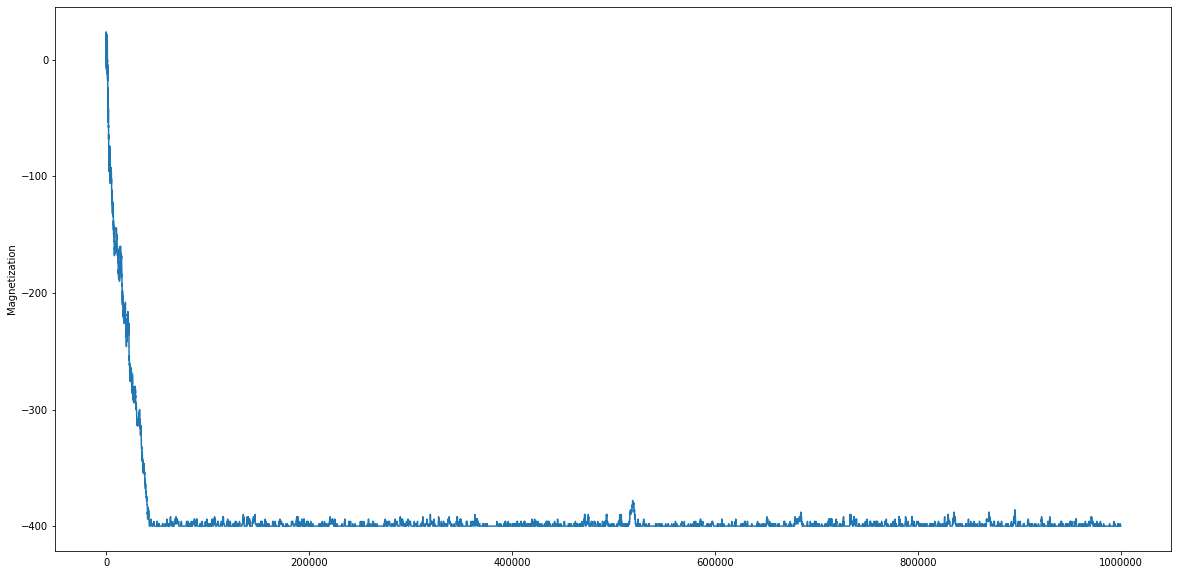

In [59]:
steps = 1000000
dimensions = 20
M = np.zeros(steps)
T = 1
kB = 1
J = 1

testArray = createLattice(dimensions,dimensions)
testArray = initializeLattice(testArray,dimensions)


for t in range(steps):
    M[t] = magnetization(testArray)
    testArray = stateChange(testArray,dimensions,T,kB,J)

plt.figure(figsize=(20, 10))
plt.plot(M,"-")
plt.ylabel("Magnetization")
plt.show()

In [64]:
animation.FuncAnimation?

In [76]:
from IPython.display import HTML

In [94]:
def initIsing():
    global isingImage
    
    L = 20
    
    ##initial lattice
    isingLattice = createLattice(L,L)
    isingLattice = initializeLattice(isingLattice,L)
    
    isingImage = plt.imshow(isingLattice, interpolation = "none", cmap = "gray")
    
    return isingImage

In [98]:
def isingAnimation(spin_array, size, T, kB, J):
    global isingImage
    
    isingImage.set_data([stateChange(spin_array,size,T,kB,J)])
    
    return isingImage

Traceback (most recent call last):
  File "C:\Users\info\AppData\Local\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\info\AppData\Local\anaconda3\lib\site-packages\matplotlib\animation.py", line 953, in _start
    self._init_draw()
  File "C:\Users\info\AppData\Local\anaconda3\lib\site-packages\matplotlib\animation.py", line 1740, in _init_draw
    for a in self._drawn_artists:
TypeError: 'AxesImage' object is not iterable


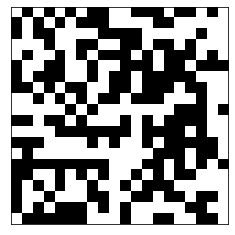

In [113]:
##define figure
fig,ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])

# Set up formatting for the movie files
#mywriter = animation.FFMpegWriter()
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.FuncAnimation(fig, isingAnimation, init_func=initIsing, 
                               fargs=(L,T,kB,J),frames=steps,interval=250,blit=True)
#anim.save('im.mp4', writer=writer)